# Creating Local RAG Pipeline from Scratch

## 1. Data Preparation

### 1.1 Importing PDF Document for our Book

In [1]:
!pip install PyMuPDF

In [3]:
!pip install tools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.9 MB/s eta 0:00:00


In [4]:
import os
import re
import fitz
import torch
import random
import requests
import textwrap
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from typing import List, Dict  # for type hints
from spacy.lang.en import English
from transformers import BitsAndBytesConfig
from transformers.utils import is_flash_attn_2_available
from sentence_transformers import util, SentenceTransformer
from transformers import AutoTokenizer, AutoModelForCausalLM

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# getting pdf documents from local system
pdf_path = "/content/drive/MyDrive/clrs.pdf"

# download pdf if not present
if not os.path.exists(pdf_path):
    print(f"Given path {pdf_path} does not exist. Downloading the pdf file!!!")
    url = "https://www.cs.mcgill.ca/~akroit/math/compsci/Cormen%20Introduction%20to%20Algorithms.pdf"

    filename = pdf_path
    response = requests.get(url)# download the file

    if response.status_code == 200: # check if the download was successful
        with open(filename, 'wb') as file:
            file.write(response.content)# save the file
        print(f"File downloaded and saved as {filename}")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")
else:
    print(f"File already exists at {pdf_path}. Proceeding to read the file.")

File already exists at /content/drive/MyDrive/clrs.pdf. Proceeding to read the file.


Sine now we have imported our file now next step is to preprocess the text as we read it. We have imported the pages of book in the `file_path` and now we can open and read it with `PyMuPDF` by typing command `import fitz`.

In [7]:
def text_formatter(text: str) -> str:
    #fixing hyphenated words split across lines
    text = re.sub(r'(\w+)-\s*\n\s*(\w+)', r'\1\2', text)
    # fixing words split across lines WITHOUT hyphens
    text = re.sub(r'(\w+)\s*\n\s*(\w+)', lambda m: m.group(1) + m.group(2) if m.group(2)[0].islower() else m.group(0), text)
    # preserve code blocks
    lines = text.split('\n')
    processed_lines = []
    in_code_block = False

    for i, line in enumerate(lines):
        stripped = line.strip()
        #skipping empty lines
        if not stripped:
            processed_lines.append('')
            continue

        # checking if code or pseudocode
        is_code_line = (
            len(line) - len(line.lstrip()) >= 4 or  # 4+ space indent
            stripped.startswith('//') or  # comment
            re.match(r'^(if|for|while|return|else)\b', stripped, re.IGNORECASE) or
            re.match(r'^[A-Z][A-Z\-]+\(', stripped)  # FUNCTION-NAME(
        )

        if is_code_line:
            in_code_block = True
            # keeping the line with a marker
            processed_lines.append('__CODELINE__' + line)
        else:
            # checking if we just exited a code block
            if in_code_block:
                processed_lines.append('__CODEEND__')
                in_code_block = False
            processed_lines.append(line)

    text = '\n'.join(processed_lines)

    #paragraph joining for non-code text where we join lines that are part of the same paragraph
    text = re.sub(
        r'(?<!__CODELINE__)(?<!__CODEEND__)(?<!\n)\n(?!__CODELINE__)(?!__CODEEND__)(?!\n)(?![A-Z])', ' ', text)
    #cleaning up markers
    text = text.replace('__CODELINE__', '')
    text = text.replace('__CODEEND__', '\n')
    #removing excessive blank lines (3+) but keep double newlines for sections
    text = re.sub(r'\n{3,}', '\n\n', text)
    #cleaning up multiple spaces (but not at line start - that's indentation)
    text = re.sub(r'([^\n]) {2,}', r'\1 ', text)
    #fixing spacing around punctuation
    text = re.sub(r'\s+([.,;:!?])', r'\1', text)
    #removing standalone page numbers (just digits on their own line)
    text = re.sub(r'^\s*\d{1,4}\s*$', '', text, flags=re.MULTILINE)
    #removing common header and footer patterns
    text = re.sub(r'^(Chapter|Section)\s+\d+.*$', '',
                  text, flags=re.MULTILINE | re.IGNORECASE)
    text = text.strip()
    return text

#detecting block of algorithm in clrs
def is_algorithm_block(text: str) -> bool:
    indicators = [
        bool(re.search(r'\b(if|then|else)\b', text, re.IGNORECASE)),
        bool(re.search(r'\b(for|while|do)\b', text, re.IGNORECASE)),
        bool(re.search(r'\breturn\b', text, re.IGNORECASE)),
        bool(re.search(r'^\s*//.*', text, re.MULTILINE)),  # comments
        bool(re.search(r'[A-Z][A-Z\-]+\([^)]*\)', text)),  # FUNCTION(...)
        bool(re.search(r'A\[\s*\d+', text)),  # Array notation A[1]
        bool(re.search(r'←|:=|=', text)),  # Assignment operators
    ]
    # Need at least 2 indicators and text should be substantial
    return sum(indicators) >= 2 and len(text.split()) > 10

#section header text
def is_section_header(text: str) -> bool:
    text = text.strip()
    if not text or len(text) > 100:
        return False

    words = text.split()
    if len(words) > 15 or len(words) < 2:
        return False
    # Skip table of contents entries (have lots of dots)
    if text.count('.') > 3:
        return False
    # Skip if it's just "Contents" or roman numerals
    if text.lower() in ['contents', 'preface', 'index', 'references']:
        return False
    # Likely a header if it doesn't end with period and isn't too long
    return not text.endswith('.')

#detecting table of contents
def is_toc_or_front_matter(text: str) -> bool:
    indicators = [
        'contents' in text.lower()[:50],
        'preface' in text.lower()[:50],
        text.count('...') > 2,  # TOC dots
        # Too many periods (TOC page numbers)
        text.count('.') > len(text.split()) * 0.5,
        # Roman numerals only
        bool(re.search(r'^[ivxlcdm]+$', text.strip(), re.IGNORECASE)),
    ]
    return any(indicators) or len(text.split()) < 5

#preserving chunk for contexts
def smart_chunker(pages_and_texts: List[Dict],
                  chunk_size: int = 1000,
                  overlap: int = 200,
                  skip_front_matter: bool = True) -> List[Dict]:
    chunks = []

    for page_data in pages_and_texts:
        text = page_data['text']
        page_num = page_data['page_number']

        # Skip if this looks like front matter
        if skip_front_matter and is_toc_or_front_matter(text):
            continue
        # Skip very short pages (likely artifacts)
        if len(text.split()) < 10:
            continue
        # Split by double newlines to get paragraphs/blocks
        blocks = re.split(r'\n\n+', text)

        current_chunk = ""
        current_chunk_metadata = {
            'page_number': page_num,
            'has_algorithm': False,
            'section_header': None
        }
        for block in blocks:
            block = block.strip()
            if not block or len(block) < 10:
                continue
            if is_section_header(block):# if we have a current chunk, save it
                if current_chunk and len(current_chunk.split()) > 10:
                    chunks.append({
                        'text': current_chunk.strip(),
                        'page_number': current_chunk_metadata['page_number'],
                        'chunk_char_count': len(current_chunk),
                        'chunk_word_count': len(current_chunk.split()),
                        'chunk_token_count': len(current_chunk) / 4,
                        'has_algorithm': current_chunk_metadata['has_algorithm'],
                        'section_header': current_chunk_metadata['section_header']
                    })

                # Start new chunk with this header
                current_chunk = block + "\n\n"
                current_chunk_metadata = {
                    'page_number': page_num,
                    'has_algorithm': False,
                    'section_header': block
                }
                continue

            # Check if this is an algorithm block
            block_has_algo = is_algorithm_block(block)
            if block_has_algo:
                current_chunk_metadata['has_algorithm'] = True

                # If adding this would exceed chunk_size significantly and we have content, save current chunk
                if len(current_chunk) + len(block) > chunk_size * 1.5 and len(current_chunk.split()) > 20:
                    chunks.append({
                        'text': current_chunk.strip(),
                        'page_number': current_chunk_metadata['page_number'],
                        'chunk_char_count': len(current_chunk),
                        'chunk_word_count': len(current_chunk.split()),
                        'chunk_token_count': len(current_chunk) / 4,
                        'has_algorithm': current_chunk_metadata['has_algorithm'],
                        'section_header': current_chunk_metadata['section_header']
                    })

                    # Start new chunk with overlap from previous
                    if len(current_chunk) > overlap:
                        # Get more than we need to find clean word boundary
                        overlap_start = max(
                            0, len(current_chunk) - overlap - 50)
                        overlap_text = current_chunk[overlap_start:]
                        # Find first complete word (space followed by word followed by space)
                        match = re.search(r'\s+(\S+\s+)', overlap_text)
                        if match:
                            # Start from the beginning of that complete word
                            overlap_text = overlap_text[match.start(1):]
                        else:
                            # Fallback: just find first space
                            space_idx = overlap_text.find(' ')
                            if space_idx > 0:
                                overlap_text = overlap_text[space_idx+1:]
                    else:
                        overlap_text = current_chunk
                    current_chunk = overlap_text + "\n\n" + block + "\n\n"
                    current_chunk_metadata = {
                        'page_number': page_num,
                        'has_algorithm': True,
                        'section_header': current_chunk_metadata['section_header']
                    }
                else:
                    # Add algorithm block to current chunk (keep it together!)
                    current_chunk += block + "\n\n"
            else:
                # Regular text block
                if len(current_chunk) + len(block) > chunk_size and len(current_chunk.split()) > 20:
                    # Save current chunk
                    chunks.append({
                        'text': current_chunk.strip(),
                        'page_number': current_chunk_metadata['page_number'],
                        'chunk_char_count': len(current_chunk),
                        'chunk_word_count': len(current_chunk.split()),
                        'chunk_token_count': len(current_chunk) / 4,
                        'has_algorithm': current_chunk_metadata['has_algorithm'],
                        'section_header': current_chunk_metadata['section_header']
                    })

                    # Start new chunk with overlap
                    if len(current_chunk) > overlap:
                        # Find word boundary for clean overlap
                        overlap_text = current_chunk[-overlap:]
                        # Adjust to start at word boundary
                        space_idx = overlap_text.find(' ')
                        if space_idx > 0:
                            overlap_text = overlap_text[space_idx+1:]
                    else:
                        overlap_text = current_chunk
                    current_chunk = overlap_text + "\n\n" + block + "\n\n"
                    current_chunk_metadata = {
                        'page_number': page_num,
                        'has_algorithm': False,
                        'section_header': current_chunk_metadata['section_header']
                    }
                else:
                    current_chunk += block + "\n\n"

        # Save the last chunk from this page if it's substantial
        if current_chunk.strip() and len(current_chunk.split()) > 10:
            chunks.append({
                'text': current_chunk.strip(),
                'page_number': current_chunk_metadata['page_number'],
                'chunk_char_count': len(current_chunk),
                'chunk_word_count': len(current_chunk.split()),
                'chunk_token_count': len(current_chunk) / 4,
                'has_algorithm': current_chunk_metadata['has_algorithm'],
                'section_header': current_chunk_metadata['section_header']
            })

    # Add chunk IDs
    for i, chunk in enumerate(chunks):
        chunk['chunk_id'] = i

    return chunks

In [8]:
def open_and_read_pdf(pdf_path: str, page_offset: int = 0) -> List[Dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc), desc="Reading PDF pages", total=len(doc)):
        text = page.get_text()
        text = text_formatter(text)
        # Skip completely empty pages
        if not text.strip():
            continue
        pages_and_texts.append({
            "page_number": page_number - page_offset,
            "pdf_page_number": page_number,  # Keep original for reference
            "page_char_count": len(text),
            "page_word_count": len(text.split()),
            "page_sentence_count_raw": len(text.split(". ")),
            "page_token_count": len(text) / 4,
            "text": text
        })

    return pages_and_texts

def find_content_start_page(pdf_path: str, sample_size: int = 50) -> int:
    doc = fitz.open(pdf_path)
    for page_num in range(min(sample_size, len(doc))):
        page = doc[page_num]
        text = page.get_text()

        #looking for indicators of actual content like chapter 1 and introduction etc.
        if re.search(r'chapter\s+1|^1\s+introduction', text, re.IGNORECASE | re.MULTILINE):
            print(f"Found likely content start at PDF page {page_num}")
            print(f"First 200 chars: {text[:200]}")
            return page_num

    print("Could not automatically find content start. Please check manually.")
    return 0

In [9]:
content_start = find_content_start_page(pdf_path)
pages_and_texts = open_and_read_pdf(pdf_path, page_offset=41)
chunks = smart_chunker(pages_and_texts, chunk_size=1000,
                       overlap=200, skip_front_matter=True)
print(f"Total pages: {len(pages_and_texts)}")
print(f"Total chunks: {len(chunks)}")
print(
    f"Chunks with algorithms: {sum(1 for c in chunks if c['has_algorithm'])}")
for i in range(50, 53):
    print(f"\n{'='*60}")
    print(f"Chunk {i}:")
    print(
        f"Page: {chunks[i]['page_number']}, Has algo: {chunks[i]['has_algorithm']}")
    print(f"Header: {chunks[i]['section_header']}")
    print(f"Text preview: {chunks[i]['text'][:300]}...")

Found likely content start at PDF page 23
First 200 chars: Introduction
This part will start you thinking about designing and analyzing algorithms. It is
intended to be a gentle introduction to how we specify algorithms, some of the
design strategies we will 


Reading PDF pages:   0%|          | 0/1313 [00:00<?, ?it/s]

Total pages: 1306
Total chunks: 1931
Chunks with algorithms: 1260

Chunk 50:
Page: 14, Has algo: True
Header: None
Text preview: 2.3
Designing algorithms 35 5 2 4 7 1 3 2 6 2 5 4 7 1 3 2 6 2 4 5 7 1 2 3 6 1 2 2 3 4 5 6 7 mergemerge mergesorted sequenceinitial sequencemerge mergemerge merge
Figure 2.4
The operation of merge sort on the array A D h5; 2; 4; 7; 1; 3; 2; 6i. The lengths of thesorted sequences being merged increase...

Chunk 51:
Page: 15, Has algo: True
Header: None
Text preview: Getting Startedthe original problem size is a power of 2. Each divide step then yields two subsequences of size exactly n=2. In Chapter 4, we shall see that this assumption doesnot affect the order of growth of the solution to the recurrence.
We reason as follows to set up the recurrence for T.n/, t...

Chunk 52:
Page: 15, Has algo: True
Header: 2T.n=2/ C ‚.n/
if n > 1:
Text preview: 2T.n=2/ C ‚.n/
if n > 1:

(2.1)
In Chapter 4, we shall see the “master theorem,” which we can use to showthat T.n/ is

In [10]:
random.sample(pages_and_texts, k=3)# finding random text from random pages

[{'page_number': 605,
  'pdf_page_number': 646,
  'page_char_count': 2152,
  'page_word_count': 427,
  'page_sentence_count_raw': 14,
  'page_token_count': 538.0,
  'text': 'Minimum Spanning Treestree. We call such an edge a safe edge for A, since we can add it safely to A whilemaintaining the invariant.\nGENERIC-MST.G; w/ 1\nA D; 2while A does not form a spanning tree 3 ﬁnd an edge.u; \x17/ that is safe for A 4\nA D A [ f.u; \x17/g 5\nreturn A\n\nWe use the loop invariant as follows:\nInitialization: After line 1, the set A trivially satisﬁes the loop invariant.\nMaintenance: The loop in lines 2–4 maintains the invariant by adding only safeedges.\nTermination: All edges added to A are in a minimum spanning tree, and so theset A returned in line 5 must be a minimum spanning tree.\nThe tricky part is, of course, ﬁnding a safe edge in line 3. One must exist, sincewhen line 3 is executed, the invariant dictates that there is a spanning tree T suchthat A \x12 T. Within the while loop body,

### 1.2 Getting Text Statistics


In [11]:
df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,pdf_page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,0,189,92,4,47.25,A L G O R I T H M S\nI N T R O D U C T I O N T...
1,-40,1,40,5,1,10.00,Introduction to Algorithms\nThird Edition
2,-38,3,165,23,4,41.25,Thomas H. Cormen\nCharles E. Leiserson\nRonald...
3,-37,4,883,127,13,220.75,c 2009 Massachusetts Institute of Technology\n...
4,-36,5,876,134,1,219.00,Contents\nPreface xiii\nI\nFoundations\nIntrod...


In [12]:
df.describe().round(2)# getting basic statistics of the dataframe

,page_number,pdf_page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1306.00,1306.00,1306.00,1306.00,1306.00,1306.00
mean,615.66,656.66,1886.35,333.99,13.02,471.59
std,378.27,378.27,562.75,94.74,9.72,140.69
min,-41.00,0.00,13.00,2.00,1.00,3.25
25%,288.25,329.25,1547.25,279.00,9.00,386.81
50%,615.50,656.50,1918.00,339.00,12.00,479.50
75%,942.75,983.75,2282.25,396.00,15.00,570.56
max,1271.00,1312.00,3225.00,570.00,103.00,806.25


### 1.3 Splitting Pages into Sentences

In [13]:
nlp = English()
nlp.add_pipe("sentencizer")
# making a document instance as an example
doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2
#Access the sentences of the document
list(doc.sents)

[This is a sentence., This another sentence.]

In [14]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)# extracting sentences using spacy
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]# Make sure all sentences are strings
    # counting the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1306 [00:00<?, ?it/s]

In [15]:
random.sample(pages_and_texts, k=1)

[{'page_number': 246,
  'pdf_page_number': 287,
  'page_char_count': 2001,
  'page_word_count': 402,
  'page_sentence_count_raw': 11,
  'page_token_count': 500.25,
  'text': '11.3\nHash functions 267 expectation, therefore, the expected time for the entire sequence of n operationsis O.n/. Since each operation takes \x7f.1/ time, the ‚.n/ bound follows.\nDesigning a universal class of hash functions\nIt is quite easy to design a universal class of hash functions, as a little numbertheory will help us prove. You may wish to consult Chapter 31 ﬁrst if you areunfamiliar with number theory.\nWe begin by choosing a prime number p large enough so that every possiblekey k is in the range 0 to p \x00 1, inclusive. Let Zp denote the set f0; 1;:::; p \x00 1g, and let Z\x03 p denote the set f1; 2;:::; p \x00 1g. Since p is prime, we can solve equations modulo p with the methods given in Chapter 31. Because we assume that thesize of the universe of keys is greater than the number of slots in the ha

In [16]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)# getting basic statistics of the dataframe

,page_number,pdf_page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1306.00,1306.00,1306.00,1306.00,1306.00,1306.00,1306.00
mean,615.66,656.66,1886.35,333.99,13.02,471.59,14.41
std,378.27,378.27,562.75,94.74,9.72,140.69,7.97
min,-41.00,0.00,13.00,2.00,1.00,3.25,1.00
25%,288.25,329.25,1547.25,279.00,9.00,386.81,10.00
50%,615.50,656.50,1918.00,339.00,12.00,479.50,14.00
75%,942.75,983.75,2282.25,396.00,15.00,570.56,17.00
max,1271.00,1312.00,3225.00,570.00,103.00,806.25,68.00


### 1.4 Splitting Sentences

The purpose of splitting our texts into smaller groups is that we want them to fit into our embedding model context window which is having 384 tokens limit.

In [17]:
num_sentence_chunk_size = 10# setting chunk size for sentences
print(f"Sentence chunk size set to: {num_sentence_chunk_size}")

#creating function to split text into sentence chunks
def split_list(input_list: list[str], slice_size:int = num_sentence_chunk_size) -> list[list[str]]:
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

test_list = list(range(25))
split_list(test_list)

Sentence chunk size set to: 10


[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [18]:
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1306 [00:00<?, ?it/s]

In [19]:
random.sample(pages_and_texts, k=1)# getting random sample of sentence chunks

[{'page_number': 405,
  'pdf_page_number': 446,
  'page_char_count': 3121,
  'page_word_count': 555,
  'page_sentence_count_raw': 19,
  'page_token_count': 780.25,
  'text': 'Greedy Algorithmstake it or leave it behind; he cannot take a fractional amount of an item or take anitem more than once.)\nIn the fractional knapsack problem, the setup is the same, but the thief can takefractions of items, rather than having to make a binary (0-1) choice for each item.\nYou can think of an item in the 0-1 knapsack problem as being like a gold ingotand an item in the fractional knapsack problem as more like gold dust.\nBoth knapsack problems exhibit the optimal-substructure property. For the 0-1problem, consider the most valuable load that weighs at most W pounds. If weremove item j from this load, the remaining load must be the most valuable loadweighing at most W \x00 wj that the thief can take from the n \x00 1 original itemsexcluding j. For the comparable fractional problem, consider that if 

In [20]:
df = pd.DataFrame(pages_and_texts)# creating dataframe
df.describe().round(2)# getting basic statistics of the dataframe

,page_number,pdf_page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1306.00,1306.00,1306.00,1306.00,1306.00,1306.00,1306.00,1306.00
mean,615.66,656.66,1886.35,333.99,13.02,471.59,14.41,1.89
std,378.27,378.27,562.75,94.74,9.72,140.69,7.97,0.83
min,-41.00,0.00,13.00,2.00,1.00,3.25,1.00,1.00
25%,288.25,329.25,1547.25,279.00,9.00,386.81,10.00,1.00
50%,615.50,656.50,1918.00,339.00,12.00,479.50,14.00,2.00
75%,942.75,983.75,2282.25,396.00,15.00,570.56,17.00,2.00
max,1271.00,1312.00,3225.00,570.00,103.00,806.25,68.00,7.00


### 1.5 Splitting Each Partition into an Item

In [21]:
pages_and_chunks = []# list to hold page and chunk information
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}# dictionary to hold chunk information
        chunk_dict["page_number"] = item["page_number"]# page number

        joined_sentence_chunk = "".join(
            sentence_chunk).replace("  ", " ").strip()# Join the sentences together into a paragraph-like structure as  chunk (so they are a single string)
        # ".A" -> ". A" for any full-stop/capital letter combo
        joined_sentence_chunk = re.sub(
            r'\.([A-Z])', r'. \1', joined_sentence_chunk)
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len(
            [word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(
            joined_sentence_chunk) / 4  # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/1306 [00:00<?, ?it/s]

2472

In [22]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 1250,
  'sentence_chunk': 'Index 1271 see also stacklight edge, 626linear constraint, 846linear dependence, 1223linear equality, 845linear equationssolving modular, 946–950solving systems of, 813–827solving tridiagonal systems of, 840pr.linear function, 26, 845linear independence, 1223linear inequality, 846linear-inequality feasibility problem, 894pr.linearity of expectation, 1198and indicator random variables, 119linearity of summations, 1146linear order, 1165linear permutation, 1229pr.linear probing, 272linear programming, 7, 843–897algorithms for, 850applications of, 849duality in, 879–886ellipsoid algorithm for, 850, 897ﬁnding an initial solution in, 886–891fundamental theorem of, 892interior-point methods for, 850, 897\nKarmarkar’s algorithm for, 897and maximum ﬂow, 860–861and minimum-cost circulation, 896pr.and minimum-cost ﬂow, 861–862and minimum-cost multicommodity ﬂow, 864ex.and multicommodity ﬂow, 862–863simplex algorithm for, 864–879, 896and single-pair shor

In [23]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,2472.00,2472.00,2472.00,2472.00
mean,649.99,995.77,169.32,248.94
std,391.42,511.97,94.10,127.99
min,-41.00,4.00,1.00,1.00
25%,317.75,569.50,86.00,142.38
50%,648.50,1033.00,172.00,258.25
75%,1001.25,1361.00,235.00,340.25
max,1271.00,2559.00,491.00,639.75


In [24]:
chunks_over_512 = df[df['chunk_token_count'] > 512].shape[0]
percentage = (chunks_over_512 / 2472) * 100

In [25]:
print(f"Number of chunks over 512 tokens: {chunks_over_512} ({percentage:.2f}%)")

Number of chunks over 512 tokens: 45 (1.82%)


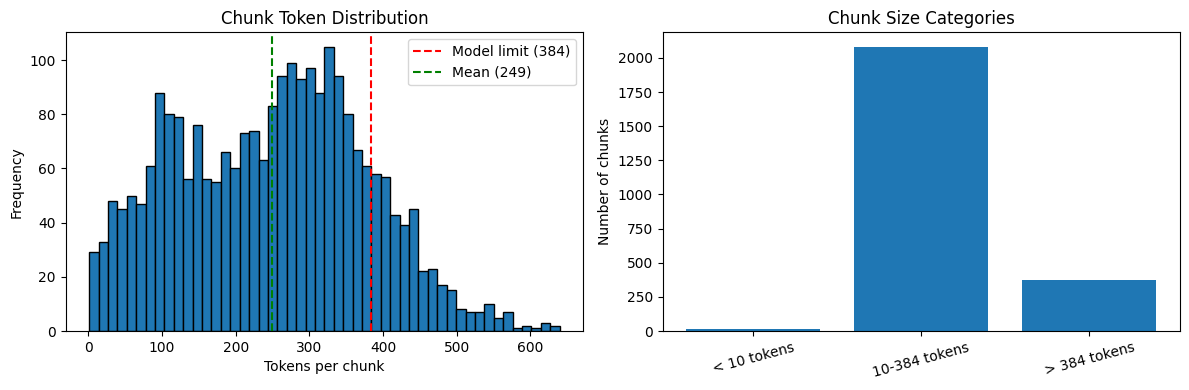


Chunk Analysis:
  Total chunks: 2472
  Too small (< 10 tokens): 17 (0.7%)
  Perfect size (10-384): 2083 (84.3%)
  Too large (> 384): 372 (15.0%)


In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

# Token count distribution
plt.subplot(1, 2, 1)
plt.hist(df['chunk_token_count'], bins=50, edgecolor='black')
plt.axvline(x=384, color='red', linestyle='--', label='Model limit (384)')
plt.axvline(x=df['chunk_token_count'].mean(), color='green',
            linestyle='--', label=f'Mean ({df["chunk_token_count"].mean():.0f})')
plt.xlabel('Tokens per chunk')
plt.ylabel('Frequency')
plt.title('Chunk Token Distribution')
plt.legend()

# Check problematic chunks
plt.subplot(1, 2, 2)
sizes = ['< 10 tokens', '10-384 tokens', '> 384 tokens']
counts = [
    len(df[df['chunk_token_count'] < 10]),
    len(df[(df['chunk_token_count'] >= 10) & (df['chunk_token_count'] <= 384)]),
    len(df[df['chunk_token_count'] > 384])
]
plt.bar(sizes, counts)
plt.ylabel('Number of chunks')
plt.title('Chunk Size Categories')
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()

print(f"\nChunk Analysis:")
print(f"  Total chunks: {len(df)}")
print(f"  Too small (< 10 tokens): {counts[0]} ({counts[0]/len(df)*100:.1f}%)")
print(f"  Perfect size (10-384): {counts[1]} ({counts[1]/len(df)*100:.1f}%)")
print(f"  Too large (> 384): {counts[2]} ({counts[2]/len(df)*100:.1f}%)")

In [27]:
print(f"Using all {len(chunks)} chunks")
print("Model will auto-truncate 372 large chunks")

Using all 1931 chunks
Model will auto-truncate 372 large chunks


In [28]:
df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count
0,-41,A L G O R I T H M S\nI N T R O D U C T I O N T...,189,85,47.25
1,-40,Introduction to Algorithms\nThird Edition,40,4,10.00
2,-38,Thomas H. Cormen\nCharles E. Leiserson\nRonald...,165,15,41.25
3,-37,c 2009 Massachusetts Institute of Technology\n...,742,93,185.50
4,-37,alk.paper) 1. Computer programming.2. Computer...,137,22,34.25


In [29]:
min_token_length = 15# setting minimum token length
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():# iterating through rows with chunk token count less than or equal to minimum token length
    print(
        f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 9.25 | Text: At least half of the medians found in
Chunk token count: 14.25 | Text: We shall investigate multithreaded algorithms written for
Chunk token count: 2.25 | Text: Show that
Chunk token count: 4.75 | Text: VI
Graph Algorithms
Chunk token count: 6.5 | Text: V
Advanced Data Structures


In [30]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -41,
  'sentence_chunk': 'A L G O R I T H M S\nI N T R O D U C T I O N T O\nT H I R D E D I T I O N\nT H O M A S H. \nC H A R L E S E. \nR O N A L D L. \nC L I F F O R D\nS T E I N\nR I V E S T\nL E I S E R S O N\nC O R M E N',
  'chunk_char_count': 189,
  'chunk_word_count': 85,
  'chunk_token_count': 47.25},
 {'page_number': -38,
  'sentence_chunk': 'Thomas H. Cormen\nCharles E. Leiserson\nRonald L. Rivest\nClifford Stein\nIntroduction to Algorithms\nThird Edition\nThe MIT Press\nCambridge, Massachusetts\nLondon, England',
  'chunk_char_count': 165,
  'chunk_word_count': 15,
  'chunk_token_count': 41.25}]

In [31]:
random.sample(pages_and_chunks_over_min_token_len, k=1)

[{'page_number': 955,
  'sentence_chunk': 'Number-Theoretic Algorithms\nPollard’s rho heuristic\nTrial division by all integers up to R is guaranteed to factor completely any numberup to R2. For the same amount of work, the following procedure, POLLARD-RHO, factors any number up to R4 (unless we are unlucky). Since the procedure is onlya heuristic, neither its running time nor its success is guaranteed, although theprocedure is highly effective in practice. Another advantage of the POLLARDRHO procedure is that it uses only a constant number of memory locations. (If youwanted to, you could easily implement POLLARD-RHO on a programmable pocketcalculator to ﬁnd factors of small numbers.)\nPOLLARD-RHO.n/ 1i D 1 2 x1 D RANDOM.0; n \x00 1/ 3y D x1 4 k D 2 5\nwhile TRUE\n\n6 i D i C 1 7 xi D.x2i\x001 \x00 1/ mod n 8 d D gcd.y \x00 xi; n/ 9if d ¤ 1 and d ¤ n 10 print d 11\nif i == k\n\n12 y D xi 13 k D 2k\nThe procedure works as follows. Lines 1–2 initialize i to 1 and x1 to a randomlychosen v

## 2. Creating Embeddings

In [32]:
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device="cpu")
sentences = [
    "If the array is already sorted in decreasing order, then, the pivot element is less than all the other elements.",
    "A return statement immediately transfers control back to the point of call in the calling procedure.",
    "The keyword error indicates that an error occurred because conditions were wrong for the procedure to have been called",
    "The time taken by the INSERTION-SORT procedure depends on the input"
]
embeddings = embedding_model.encode(sentences)# creating embeddings for the sentences
embeddings_dict = dict(zip(sentences, embeddings))# creating a dictionary of sentences and their embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence: If the array is already sorted in decreasing order, then, the pivot element is less than all the other elements.
Embedding: [-7.57871196e-02 -1.22801699e-01 -9.92374867e-03  3.83852124e-02
  1.09934611e-02 -2.47955788e-02 -2.62984838e-02 -3.41289341e-02
  1.38154002e-02  5.26515022e-02  4.05467078e-02  6.77561387e-02
  5.65901101e-02  2.12848783e-02  8.45209509e-03  2.87762005e-03
  8.74242466e-03 -6.80725556e-03  3.81464995e-02  4.65782434e-02
 -2.48107761e-02 -2.30073202e-02 -4.36397679e-02  7.21045816e-03
  7.42234960e-02  1.12223327e-02  4.17783624e-03  4.55432534e-02
  3.59459966e-02  1.36191081e-02 -4.39491048e-02  2.93692145e-02
 -1.42446784e-02 -7.34402463e-02  1.43368277e-06 -2.11692471e-02
  6.15318120e-03 -1.27934106e-02  5.23716956e-02 -1.58440173e-02
  5.28000109e-03 -3.50435600e-02 -4.20864895e-02 -9.55967326e-03
  3.84487724e-03 -4.66262810e-02 -2.23881509e-02  4.07273918e-02
  3.36725712e-02 -2.13507898e-02  2.27865251e-03 -1.48711568e-02
  8.37336704e-02 -2.0

In [33]:
embeddings[0].shape

(768,)

In [34]:
%%time

embedding_model.to("cuda")
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/2438 [00:00<?, ?it/s]

CPU times: user 54.5 s, sys: 482 ms, total: 55 s
Wall time: 56.6 s


In [35]:
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len] # extracting sentence chunks

In [36]:
text_chunk_embeddings = embedding_model.encode(text_chunks, batch_size=32,  convert_to_tensor=True)
text_chunk_embeddings

tensor([[-0.0655, -0.0349, -0.0133,  ...,  0.0538, -0.0036,  0.0226],
        [-0.0205, -0.0198, -0.0266,  ..., -0.0105,  0.0293,  0.0002],
        [-0.0267,  0.0273, -0.0267,  ...,  0.0045, -0.0064, -0.0122],
        ...,
        [-0.0291, -0.0511, -0.0353,  ..., -0.0154, -0.0059, -0.0303],
        [-0.0451, -0.0541, -0.0558,  ..., -0.0193, -0.0117, -0.0444],
        [-0.0024,  0.0425, -0.0220,  ...,  0.0353, -0.0073, -0.0338]],
       device='cuda:0')

In [37]:
#saving embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [38]:
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)# loading the saved embeddings from file
text_chunks_and_embedding_df_load.head()# displaying the head of the loaded dataframe

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-41,A L G O R I T H M S\nI N T R O D U C T I O N T...,189,85,47.25,[-6.54905885e-02 -3.49067152e-02 -1.33199394e-...
1,-38,Thomas H. Cormen\nCharles E. Leiserson\nRonald...,165,15,41.25,[-2.05252320e-02 -1.97693743e-02 -2.66364869e-...
2,-37,c 2009 Massachusetts Institute of Technology\n...,742,93,185.50,[-2.66846363e-02 2.72525121e-02 -2.67212223e-...
3,-37,alk.paper) 1. Computer programming.2. Computer...,137,22,34.25,[-2.02265009e-02 -3.64451930e-02 -3.75404321e-...
4,-36,Contents\nPreface xiii\nI\nFoundations\nIntrod...,874,106,218.50,[ 3.65014076e-02 2.32188334e-03 -9.05453786e-...


## 2. Implementing RAG

### 2.1 Building Similarity Search

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# importing the saved embeddings from file
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=' '))# converting string representation of embeddings back to numpy arrays
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")# creating a list of dictionaries from the dataframe
#converting embeddings to torch tensor
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape


torch.Size([2438, 768])

In [40]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-41,A L G O R I T H M S\nI N T R O D U C T I O N T...,189,85,47.25,"[-0.0654905885, -0.0349067152, -0.0133199394, ..."
1,-38,Thomas H. Cormen\nCharles E. Leiserson\nRonald...,165,15,41.25,"[-0.020525232, -0.0197693743, -0.0266364869, 0..."
2,-37,c 2009 Massachusetts Institute of Technology\n...,742,93,185.50,"[-0.0266846363, 0.0272525121, -0.0267212223, 0..."
3,-37,alk.paper) 1. Computer programming.2. Computer...,137,22,34.25,"[-0.0202265009, -0.036445193, -0.0375404321, 0..."
4,-36,Contents\nPreface xiii\nI\nFoundations\nIntrod...,874,106,218.50,"[0.0365014076, 0.00232188334, -0.00905453786, ..."


In [41]:
embeddings[0]

tensor([-6.5491e-02, -3.4907e-02, -1.3320e-02, -3.0557e-02, -7.1670e-03,
        -3.6069e-03,  5.3057e-02,  1.0428e-03, -6.4981e-03,  8.5996e-02,
         2.3541e-02,  3.5456e-02,  1.9934e-02,  2.9792e-03,  2.5451e-02,
        -8.5283e-03,  3.1516e-02,  2.1661e-02, -1.5421e-02, -1.4429e-02,
        -1.6294e-02,  4.0420e-02, -2.1802e-02,  2.5963e-02, -3.6387e-02,
        -4.3070e-02, -4.8037e-02,  6.1059e-03, -3.2668e-02, -9.0321e-02,
        -2.2475e-02,  8.8632e-02, -5.5577e-02, -2.1637e-02,  2.8706e-06,
         2.9119e-02, -3.2738e-02,  1.3039e-02,  2.5247e-02,  4.8846e-02,
        -1.8605e-02, -2.8403e-02,  1.0017e-02, -6.9018e-03, -1.4089e-03,
         2.8063e-02,  4.5527e-04, -7.3024e-03,  6.2203e-03, -3.2058e-02,
        -5.7860e-03, -2.7900e-02, -4.8312e-02, -2.5911e-02,  5.4761e-02,
        -3.1544e-02,  1.2536e-02,  4.6934e-02,  2.8765e-02, -5.8214e-04,
        -2.4560e-02,  2.7026e-02, -1.7073e-02, -2.5599e-02,  5.2389e-02,
        -3.1122e-02, -1.6174e-02, -1.5499e-02,  3.4

In [42]:
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device=device)

#### Performing Semantic Search

1. First of all we define a query string for example **insertion sort**.
2. Then we turn the query string in an embedding with same model we used to embed our text chunks.
3. After this we perform a dot product or cosine similarity function between the text embeddings and the query embedding to get similarity scores.
4. Finally we sort the results from step 3 in descending order and use these values to inspect the texts.

In [43]:
# step-1: defining the query string
query = "insertion sort"
print(f"Query: {query}")

Query: insertion sort


In [44]:
# step-2: embedding the query string to same numerical space as text chunks and with same model
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to(device)

In [45]:
# step-3: getting similarity scores between text chunk embeddings and query embedding
from time import perf_counter as timer
start_time = timer()
dot_scores = util.dot_score(query_embedding, embeddings)[0]  # shape: (num_chunks,)
end_time = timer()
print(f"Dot product scores computed in {end_time - start_time:.4f} seconds")

Dot product scores computed in 0.0226 seconds


In [46]:
# getting the top-k results
top_results_dot_product = torch.topk(dot_scores, k=5)
print("\nTop 5 results (Dot Product):")
for score, idx in zip(top_results_dot_product.values, top_results_dot_product.indices):
    print(f"Score: {score.item():.4f}")
    print(f"Text Chunk: {pages_and_chunks[idx]['sentence_chunk']}\n")


Top 5 results (Dot Product):
Score: 0.6413
Text Chunk: Sorting in Linear Time ≤ > ≤ > 1:2 2:3 1:3 〈1,2,3〉 1:3 〈2,1,3〉 2:3 〈1,3,2〉 〈3,1,2〉 〈3,2,1〉 ≤ > ≤ > ≤ > 〈2,3,1〉
Figure 8.1
The decision tree for insertion sort operating on three elements. An internal node annotated by i:j indicates a comparison between ai and aj. A leaf annotated by the permutationh.1/; .2/;:::; .n/i indicates the ordering a.1/  a.2/      a.n/. The shaded pathindicates the decisions made when sorting the input sequence ha1 D 6; a2 D 8; a3 D 5i; thepermutation h3; 1; 2i at the leaf indicates that the sorted ordering is a3 D 5  a1 D 6  a2 D 8.
There are 3Š D 6 possible permutations of the input elements, and so the decision tree must have atleast 6 leaves.they yield identical information about the relative order of ai and aj. We thereforeassume that all comparisons have the form ai  aj.
The decision-tree model
We can view comparison sorts abstractly in terms of decision trees. A decisiontree is a full

In [47]:
top_results_dot_product

torch.return_types.topk(
values=tensor([0.6413, 0.6313, 0.6301, 0.6187, 0.6129], device='cuda:0'),
indices=tensor([349,  56, 380,  58,  59], device='cuda:0'))

In [48]:
# testing bigger size of embedding
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")
#dot product scoring time test across larger embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([243800, 768])
Time take to get scores on 243800 embeddings: 0.00045 seconds.


In [49]:
def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)# wrapping the text to specified length
    print(wrapped_text)

In [50]:
print(f"Query: '{query}'\n")# printing the query
print("Results:")
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):# iterating through the top results
    print(f"Score: {score:.4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]['sentence_chunk'])
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'insertion sort'

Results:
Score: 0.6413
Text:
Sorting in Linear Time ≤ > ≤ > 1:2 2:3 1:3 〈1,2,3〉 1:3 〈2,1,3〉 2:3 〈1,3,2〉
〈3,1,2〉 〈3,2,1〉 ≤ > ≤ > ≤ > 〈2,3,1〉 Figure 8.1 The decision tree for insertion
sort operating on three elements. An internal node annotated by i:j indicates a
comparison between ai and aj. A leaf annotated by the permutationh.1/;
.2/;:::; .n/i indicates the ordering a.1/  a.2/      a.n/. The shaded
pathindicates the decisions made when sorting the input sequence ha1 D 6; a2 D
8; a3 D 5i; thepermutation h3; 1; 2i at the leaf indicates that the sorted
ordering is a3 D 5  a1 D 6  a2 D 8. There are 3Š D 6 possible permutations of
the input elements, and so the decision tree must have atleast 6 leaves.they
yield identical information about the relative order of ai and aj. We
thereforeassume that all comparisons have the form ai  aj. The decision-tree
model We can view comparison sorts abstractly in terms of decision trees. A
decisiontree is a full b

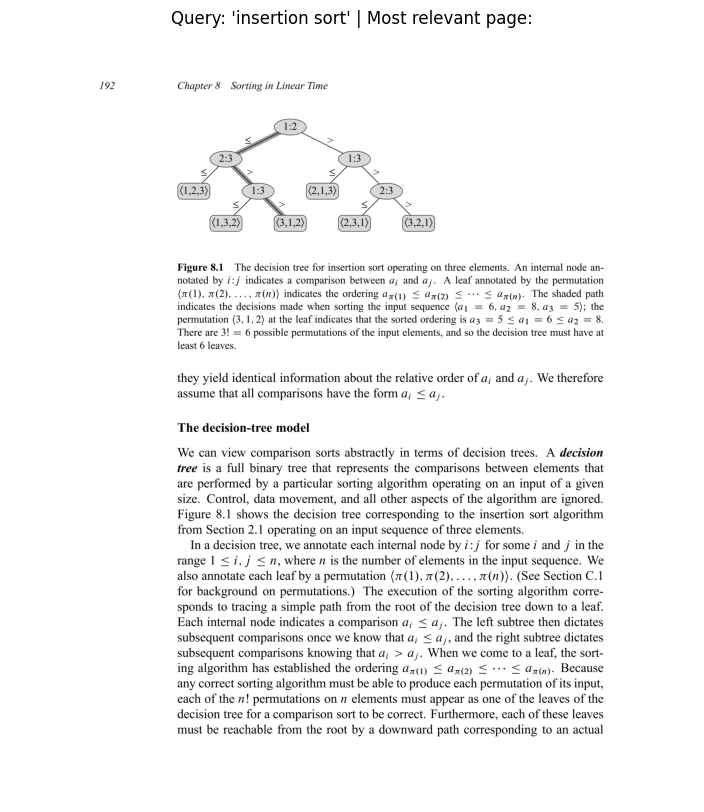

In [51]:
pdf_path = "/content/drive/MyDrive/clrs.pdf"
doc = fitz.open(pdf_path)# opening the pdf document
page = doc.load_page(171+41)#

# Get the image of the page
img = page.get_pixmap(dpi=300)
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv, dtype=np.uint8).reshape((img.h, img.w, img.n))
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off')
plt.show()

#### Workflow for Document Retrieval
```
Upload documents -> Split into chunks -> Embed chunks -> Make a query -> Embed the query with same model -> Compare query embedding to chunk embeddings
```

In [52]:
if torch.backends.mps.is_available():
    # For MPS (Apple Silicon), we need to check system memory
    # as MPS uses unified memory architecture
    import psutil

    # Get total system memory (unified on Apple Silicon)
    total_memory_bytes = psutil.virtual_memory().total
    gpu_memory_gb = round(total_memory_bytes / (2**30))
    print(f"Available GPU memory (unified): {gpu_memory_gb} GB")
else:
    print("MPS backend not available")

MPS backend not available


### Dot Product and Cosine Similarity

In [53]:
def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)# calculating dot product between two vectors

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)# calculating dot product between two vectors
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))# calculating norm of vector1
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))# calculating norm of vector2
    return dot_product / (norm_vector1 * norm_vector2)# calculating cosine similarity between two vectors


# Example tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

print("Cosine similarity between vector1 and vector2:",
      cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:",
      cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:",
      cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


### Putting Semantic Search Pipeline in a Function

In [54]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    query_embedding = model.encode(query, convert_to_tensor=True)# embedding the query string
    #dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]# shape: (num_chunks,)
    end_time = timer()
    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")
    scores, indices = torch.topk(input=dot_scores, k=n_resources_to_return)# getting the top-k results
    return scores, indices

In [55]:
def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    print(f"Query: {query}\n")
    print("Results:")
    # iterating hrough zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index] ['page_number']}")
        print("\n")

In [56]:
query = "dynamic programming approach to solve optimization problems"
scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 2438 embeddings: 0.00008 seconds.


(tensor([0.7671, 0.6961, 0.6791, 0.6642, 0.6461], device='cuda:0'),
 tensor([644, 679, 643, 645, 646], device='cuda:0'))

In [57]:
print_top_results_and_scores(query=query,embeddings=embeddings)

[INFO] Time taken to get scores on 2438 embeddings: 0.00009 seconds.
Query: dynamic programming approach to solve optimization problems

Results:
Score: 0.7671
When developing a dynamic-programming algorithm, we follow a sequence offour
steps: 1. Characterize the structure of an optimal solution.2. Recursively deﬁne
the value of an optimal solution.3. Compute the value of an optimal solution,
typically in a bottom-up fashion.4. Construct an optimal solution from computed
information. Steps 1–3 form the basis of a dynamic-programming solution to a
problem. If weneed only the value of an optimal solution, and not the solution
itself, then wecan omit step 4.
Page number: 338


Score: 0.6961
15.3 Elements of dynamic programming 379 mization problem must have in order for
dynamic programming to apply: optimalsubstructure and overlapping subproblems.
We also revisit and discuss more fullyhow memoization might help us take
advantage of the overlapping-subproblemsproperty in a top-down recursi

## 3. LLM for Local Generation

#### Checking GPU Suitable for the system

In [58]:
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 15 GB


In [59]:
if gpu_memory_gb < 5.1:
    print(
        f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(
        f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(
        f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(
        f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 15 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


#### Setting up LLM Locally

In [62]:
from huggingface_hub import notebook_login
notebook_login()

In [65]:
!pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 15.8 MB/s eta 0:00:00


In [66]:
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

In [67]:
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

[INFO] Using attention implementation: sdpa


In [68]:
model_id = "google/gemma-2b-it"
model_id = model_id # (we already set this above)
print(f"[INFO] Using model_id: {model_id}")

[INFO] Using model_id: google/gemma-2b-it


In [69]:
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [70]:
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16,
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False,
                                                 attn_implementation=attn_implementation)

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [71]:
if not use_quantization_config:
  llm_model.to("cuda")

In [72]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
      )
    )
    (norm): GemmaRMSNorm((2048,), 

#### Number of Parameters AND Size of the Model

In [73]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

2506172416

In [76]:
def get_model_mem_size(model: torch.nn.Module):
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 5012345344, 'model_mem_mb': 4780.15, 'model_mem_gb': 4.67}

#### Generating Texts with our LLM

In [77]:
input_text = "What is insertion sort and how it is better or worse than other sorting algorithm?"
#creating prompt template for it-model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")


Prompt (formatted):
<bos><start_of_turn>user
What is insertion sort and how it is better or worse than other sorting algorithm?<end_of_turn>
<start_of_turn>model



#### Tokenizing The Text

In [78]:
%%time
input_ids = tokenizer(prompt, return_tensors = "pt").to("cuda")
print(f"Model input(tokenized): \n{input_ids}\n")
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256)# 256 is max number of enew tokens created
print(f"Model output (tokens):\n{outputs[0]}\n")

Model input(tokenized): 
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    603,  49530,   6728,
            578,   1368,    665,    603,   2525,    689,  12302,   1178,   1156,
          44453,  14685, 235336,    107,    108,    106,   2516,    108]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]], device='cuda:0')}

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    603,  49530,   6728,
           578,   1368,    665,    603,   2525,    689,  12302,   1178,   1156,
         44453,  14685, 235336,    107,    108,    106,   2516,    108,  21404,
        235269,   1517, 235303, 235256,    476,  25497,    576,  49530,   6728,
        235292,    109,    688, 154509,  31938,  66058,    109, 235287, 155990,
          6728,    603,    476,   3890,  44453,  14685,    674,   3598,    731,
         76095,   1853,   5356,    576,    573,   3352,   128

In [79]:
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What is insertion sort and how it is better or worse than other sorting algorithm?<end_of_turn>
<start_of_turn>model
Sure, here's a breakdown of insertion sort:

**Insertion Sort:**

* Insertion sort is a simple sorting algorithm that works by inserting each element of the array into its correct position in the sorted subarray.
* It starts by comparing the first two elements of the array.
* If the first element is greater than the second element, the two elements are swapped.
* The algorithm then compares the second element to the third element, and so on.
* This process continues until the last element in the array has been compared to the element before it.
* Insertion sort has a time complexity of O(n^2), where n is the length of the array.

**Pros of Insertion Sort:**

* Simple and easy to understand.
* Has a time complexity that is generally O(n^2), which is often faster than other sorting algorithms.
* Stable, meaning that the

In [80]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: What is insertion sort and how it is better or worse than other sorting algorithm?

Output text:
Sure, here's a breakdown of insertion sort:

**Insertion Sort:**

* Insertion sort is a simple sorting algorithm that works by inserting each element of the array into its correct position in the sorted subarray.
* It starts by comparing the first two elements of the array.
* If the first element is greater than the second element, the two elements are swapped.
* The algorithm then compares the second element to the third element, and so on.
* This process continues until the last element in the array has been compared to the element before it.
* Insertion sort has a time complexity of O(n^2), where n is the length of the array.

**Pros of Insertion Sort:**

* Simple and easy to understand.
* Has a time complexity that is generally O(n^2), which is often faster than other sorting algorithms.
* Stable, meaning that the sorting order of equal elements is preserved.

**Cons of Inse

In [81]:
gpt4_questions = [
    "What is the difference between divide-and-conquer and dynamic programming?",
    "Explain how merge sort works and what is its time complexity?",
    "What is the Master Theorem and when do we use it?"
    "Compare the time complexity of quicksort and heapsort. Which one is better in the worst case?"
]

manual_questions = [
    "What are the differences between BFS and DFS graph traversal algorithms?",
    "Explain the greedy approach in algorithms. Give an example where it works optimally.",
    "How does Dijkstra's algorithm work and what are its limitations? Can it handle negative edge weights?",
    "What is a Red-Black tree and what properties does it maintain?"
]

query_list = gpt4_questions + manual_questions

In [82]:
query = random.choice(query_list)
print(f"Query: {query}")
#scores and indices of top result
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices


Query: How does Dijkstra's algorithm work and what are its limitations? Can it handle negative edge weights?
[INFO] Time taken to get scores on 2438 embeddings: 0.00106 seconds.


(tensor([0.6423, 0.6355, 0.6069, 0.6056, 0.5708], device='cuda:0'),
 tensor([1198, 1205, 1199, 1269, 1267], device='cuda:0'))

#### Augmenting Our Prompt

In [83]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What is the difference between divide-and-conquer and dynamic programming?
Answer: Divide-and-conquer and dynamic programming are both algorithm design paradigms, but they differ in how they handle subproblems. Divide-and-conquer breaks a problem into independent subproblems, solves them recursively, and combines their solutions. Each subproblem is solved only once and they don't overlap. Examples include merge sort and quicksort. Dynamic programming, on the other hand, is used when subproblems overlap - meaning the same subproblem is solved multiple times. It stores the results of subproblems (memoization or tabulation) to avoid redundant computation. This technique is optimal for problems exhibiting optimal substructure and overlapping subproblems, such as the Fibonacci sequence, longest common subsequence, and matrix chain multiplication.
\nExample 2:
Query: How does merge sort work and what is its time complexity?
Answer: Merge sort is a divide-and-conquer algorithm that works by recursively dividing the input array into two halves until each subarray contains a single element. Then it merges these subarrays in a sorted manner. The merge operation compares elements from two sorted subarrays and combines them into a single sorted array. The time complexity of merge sort is O(n log n) in all cases (best, average, and worst), where n is the number of elements. This is because the array is divided log n times (the height of the recursion tree), and at each level, merging takes O(n) time. The space complexity is O(n) due to the temporary arrays needed for merging. Merge sort is stable and guarantees consistent performance regardless of input distribution.
\nExample 3:
Query: What is the Master Theorem and when do we use it?
Answer: The Master Theorem provides a cookbook method for solving recurrence relations of the form T(n) = aT(n/b) + f(n), where a ≥ 1 and b > 1 are constants, and f(n) is an asymptotically positive function. It's used to determine the time complexity of divide-and-conquer algorithms. The theorem compares f(n) with n^(log_b(a)) and provides three cases: Case 1 applies when f(n) is polynomially smaller than n^(log_b(a)), resulting in T(n) = Θ(n^(log_b(a))). Case 2 applies when they're asymptotically equal, resulting in T(n) = Θ(n^(log_b(a)) log n). Case 3 applies when f(n) is polynomially larger, resulting in T(n) = Θ(f(n)). This theorem is particularly useful for analyzing algorithms like merge sort, binary search, and Strassen's matrix multiplication without having to solve the recurrence from scratch.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    # Update base prompt with context items and query
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [84]:
query = random.choice(query_list)
print(f"Query: {query}")
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
#list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: Explain the greedy approach in algorithms. Give an example where it works optimally.
[INFO] Time taken to get scores on 2438 embeddings: 0.00012 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What is the difference between divide-and-conquer and dynamic programming?
Answer: Divide-and-conquer and dynamic programming are both algorithm design paradigms, but they differ in how they handle subproblems. Divide-and-conquer breaks a problem into independent subproblems, solves them recursively, and combines their solutions. Each subproblem is solved only once and they don't overlap. Examples include merge sort and quicksort. Dynamic programmin

#### Tokenizing and Passing to LLM

In [85]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True,
                             max_new_tokens=256) # how many new tokens to generate from prompt

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: Explain the greedy approach in algorithms. Give an example where it works optimally.
RAG answer:
<bos>**Explanation of Greedy Approach:**

Sure, here's an explanation of the greedy approach in algorithms, along with an example where it works optimally:

**Greedy Property:**
A greedy algorithm obtains an optimal solution to a problem by making a sequence of choices that appear to be the best at the moment. This approach exploits substructure, meaning that the optimal solution can be constructed by considering only a subset of the available information.

**Example:**
Consider the activity selection problem, where the goal is to select a set of activities that yields the highest possible total reward. A greedy algorithm can be used to solve this problem.

**Steps of Greedy Algorithm:**
1. Determine the optimal substructure of the problem.
2. Develop a recursive solution to solve subproblems.
3. Combine the optimal solutions to solve the original problem.

**Optimal Substructure:**


#### Text Formatting

In [86]:
def ask(query,
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True,
        return_answer_only=True):
    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU

    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text

    return output_text, context_items

In [87]:
query = random.choice(query_list)
print(f"Query: {query}")
answer, context_items = ask(query=query,
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items

Query: What is the Master Theorem and when do we use it?Compare the time complexity of quicksort and heapsort. Which one is better in the worst case?
[INFO] Time taken to get scores on 2438 embeddings: 0.00013 seconds.
Answer:

**Master Theorem**  The Master Theorem provides a cookbook method for solving
recurrence relations of the form T(n) = aT(n/b) + f(n), where a ≥ 1 and b > 1
are constants, and f(n) is an asymptotically positive function. The theorem
allows us to determine the time complexity of divide-and-conquer algorithms by
comparing the function f(n) with a function of the form nlogb a.   **Comparison
of Time Complexity**  - **Quicksort:** Time complexity O(n log n), where n is
the length of the input array. - **HeapSort:** Time complexity O(h), where h is
the height of the heap, which is approximately log(n) in this case.  **The
worst-case running time of MAX-HEAPIFY is O(n log n) because it recursively
calls itself on each node in the heap, resulting in a depth of log(n) in

[{'page_number': 154,
  'sentence_chunk': 'Best-case partitioning\nIn the most even possible split, PARTITION produces two subproblems, each ofsize no more than n=2, since one is of size bn=2c and one of size dn=2e',
  'chunk_char_count': 782,
  'chunk_word_count': 128,
  'chunk_token_count': 195.5,
  'embedding': array([-2.75258068e-02, -8.62351507e-02, -1.73423495e-02,  4.11650501e-02,
         -1.03312559e-01,  5.17655676e-03,  1.66122930e-03, -1.12954807e-02,
         -4.04003970e-02, -1.98154841e-02,  4.51480336e-02,  1.21179577e-02,
         -2.36771517e-02,  3.24473600e-03, -9.20518953e-03, -5.10844588e-02,
         -6.33339584e-03,  3.80192272e-04, -3.15258503e-02, -9.78668686e-03,
         -2.69373469e-02, -3.37084793e-02, -3.48636620e-02, -1.20607726e-02,
          4.04363647e-02, -1.36111118e-02,  9.92713496e-03,  3.79689336e-02,
         -7.11081773e-02, -2.38526613e-02, -3.52650508e-02,  2.03924812e-02,
          2.05531977e-02,  7.39256516e-02,  1.88905040e-06,  3.4476388